In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "large_movies_data_with_details.csv"
df = pd.read_csv(DATA_PATH)


In [3]:
# drop rows with missing numeric fields
langs = ['en','fr','ja']
num_feats = ['popularity','vote_average','vote_count','budget','revenue','runtime']
df = df[df['original_language'].isin(langs)].dropna(subset=num_feats)

In [4]:
# Encode & split
le = LabelEncoder()
df['lang_enc'] = le.fit_transform(df['original_language'])

X = df[num_feats].values
y = df['lang_enc'].values

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.3, random_state=42, stratify=y
)

In [5]:
print("First 5 rows of TRAINING data (before scaling):")
print(pd.DataFrame(X_train, columns=num_feats).head(), "\n")

print("First 5 rows of TEST data (before scaling):")
print(pd.DataFrame(X_test,  columns=num_feats).head(),  "\n")


First 5 rows of TRAINING data (before scaling):
   popularity  vote_average  vote_count       budget      revenue  runtime
0       3.828         6.680       377.0          0.0          0.0    100.0
1       4.123         7.429      3461.0  100000000.0   30552111.0    153.0
2       3.831         7.009      1478.0   17200000.0   23800000.0    115.0
3       4.491         7.628     16971.0   81000000.0  414351546.0    129.0
4       3.861         7.223      5069.0   80000000.0  311950384.0    104.0 

First 5 rows of TEST data (before scaling):
   popularity  vote_average  vote_count      budget      revenue  runtime
0       3.862         5.800      2744.0   5500000.0   62198461.0     89.0
1       3.839         6.146       213.0         0.0          0.0     87.0
2       4.089         6.942      3551.0  22000000.0   51695362.0    100.0
3       4.190         6.873      7905.0  50100000.0  153962963.0    105.0
4       3.653         8.147      1649.0         0.0          0.0      6.0 



In [6]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [7]:
print("First 5 rows of TRAINING data (after scaling):")
print(pd.DataFrame(X_train_scaled, columns=num_feats).head(), "\n")

print("First 5 rows of TEST data (after scaling):")
print(pd.DataFrame(X_test_scaled,  columns=num_feats).head(),  "\n")


First 5 rows of TRAINING data (after scaling):
   popularity  vote_average  vote_count    budget   revenue   runtime
0   -0.437310     -0.117369   -0.820970 -0.761176 -0.612412 -0.470086
1    0.025524      0.843093   -0.201915  0.736132 -0.499610  1.813938
2   -0.432603      0.304516   -0.599965 -0.503639 -0.524540  0.176336
3    0.602889      1.098275    2.509964  0.451644  0.917412  0.779663
4   -0.385535      0.578934    0.120861  0.436671  0.539338 -0.297707 

First 5 rows of TEST data (after scaling):
   popularity  vote_average  vote_count    budget   revenue   runtime
0   -0.383966     -1.245815   -0.345839 -0.678824 -0.382769 -0.944129
1   -0.420052     -0.802131   -0.853890 -0.761176 -0.612412 -1.030319
2   -0.027820      0.218600   -0.183849 -0.431768 -0.421547 -0.470086
3    0.130642      0.130120    0.690134 -0.011025 -0.043966 -0.254612
4   -0.711872      1.763802   -0.565640 -0.761176 -0.612412 -4.520997 



In [8]:
#| Build & train ensemble
clf_rf  = RandomForestClassifier(n_estimators=100, random_state=42)
clf_lr  = LogisticRegression(max_iter=1000, random_state=42)
clf_svc = SVC(kernel='linear', probability=True, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf',clf_rf),('lr',clf_lr),('svc',clf_svc)],
    voting='soft'
)
ensemble.fit(X_train_scaled, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('svc',
                              SVC(kernel='linear', probability=True,
                                  random_state=42))],
                 voting='soft')

In [9]:
# Evaluate
y_pred = ensemble.predict(X_test_scaled)

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm, "\n")

=== Confusion Matrix ===
[[255   0   1]
 [ 24  14   0]
 [ 10   0   0]] 



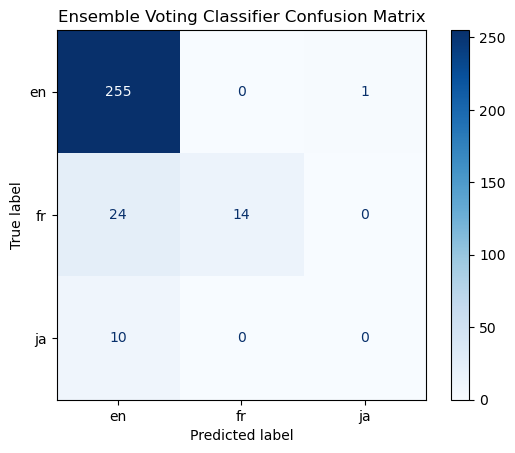

In [10]:
# Ploting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Ensemble Voting Classifier Confusion Matrix")
plt.show()

In [11]:
# classification report
print("Classification Report")
print(classification_report(
    y_test, y_pred,
    target_names=le.classes_,
    digits=4
))

Classification Report
              precision    recall  f1-score   support

          en     0.8824    0.9961    0.9358       256
          fr     1.0000    0.3684    0.5385        38
          ja     0.0000    0.0000    0.0000        10

    accuracy                         0.8849       304
   macro avg     0.6275    0.4548    0.4914       304
weighted avg     0.8680    0.8849    0.8553       304

